# Mean-field approximation of a branching process with a carrying capacity

## Nonlinear Yule process

We consider a nonlinear variation on the Yule (simple pure-birth) process.

---
**Note**
The model below seems like a special case of what this paper describes: https://arxiv.org/abs/1510.03238

Actually, is this paper doing essentially the same thing we are, restricted to the single-type case?

---

### Standard Yule process

The continuous-time Markov chain $X_t$ takes values in $\mathbb{N}_0$ representing particle number (or population size).
WLOG set the particle birth rate to unity, so that the total birth rate is simply equal to the population size $X_t$ (this is equivalent to setting the timescale).
Let $p_n(t) \equiv \mathbb{P}(X_t=n)$.
Then the standard Yule process master equation is
$$
p'_n(t) = (n - 1) \, p_{n - 1}(t) - n \, p_n(t), \quad n=1,2,\ldots,
$$
With initial conditions
$$
p_n(0) = \delta_{n,1} \quad n=0,1,\ldots.
$$
In row vector form we write
$$
\mathbf{p}'(t) = \mathbf{p}(t)Q, \quad \mathbf{p}(0) = \mathbf{e}_1,
$$
where $\mathbf{e}_1 = [0, 1, 0, 0, \dots]$ is the indicator distribution for an atom at $n=1$ (also the second canonical basis vector of $\mathbb{R}^\infty$, if we adopt 0-based indexing),
and $Q$ denotes the transition rate matrix
$$
Q \equiv \begin{bmatrix}
0 & 0 & 0 & 0 & \cdots\\
0 & -1  & 1 & 0 & \cdots\\
0 & 0 & -2 & 2 & \cdots\\
0 & 0 & 0 & -3 & \cdots\\
\vdots & \vdots & \vdots & \vdots & \ddots
\end{bmatrix}
$$

### Modeling carrying capacity

#### Strong coupling

Now, consider a logistically modulated birth rate parameterized by a carrying capacity $\kappa\in\mathbb{N}$, such that the particle-wise birth rate of the process $X_t$ is
$$
1 - \frac{1}{\kappa}X_t,
$$
and thus stochastic.
If $\kappa$ is large, then the birth rate initially remains approximately unity, but as the population size approaches the capacity $\kappa$, the birth rate decays to zero.
Whereas the standard Yule process enjoys independence for any partition of the population, the modulation proposed above introduces interactions that render it a fully coupled many-particle system.

#### Mean-field coupling

We propose a mean-field approximation to this system by introducing an $N$-system of replica Yule processes $X_t^{1,N},\dots, X_t^{N,N}$ that are weakly coupled via their empirical measure, rather than strongly coupled via their state as above.
In this approximation, the birth rate of each particle in each replica $i$ depends on the mean population size over replicas as
$$
1 - \frac{1}{\kappa}\frac{1}{N}\sum_{i=1}^N X_t^{i,N} = 1 - \frac{1}{\kappa}\frac{1}{N}\sum_{i=1}^N\sum_{n=0}^\infty \delta_{X_t^{i,N}}(n) = 1 - \frac{1}{\kappa}\mathbb{E}_{Y\sim\mathcal{P}^N_t}[Y],
$$
where $\mathcal{P}^N_t$ denotes the stochastic empirical measure of the $N$-system at time $t$,
$$
\mathcal{P}^N_t \equiv \frac{1}{N}\sum_{i=1}^N \delta_{X_t^{i,N}}.
$$

#### Propagation of chaos

By propagation of chaos, there exists a deterministic measure $\mu_t$ such that $\mathcal{P}^N_t \to \mathcal{P}^\infty_t = \mu_t$ as $N\to\infty$, and $X_t^{i,\infty}\sim \mu_t \ \ \forall i$.
In this limit, all interaction has disappeared, and we have the limiting birth rate
$$
1 - \frac{1}{\kappa}\mathbb{E}_{X_t\sim\mu_t}[X_t],
$$
Furthermore, because the deterministic measure $\mu_t$ is the measure of the population size for one replica, we arrive at a nonlinear master equation in the mean-field limit
$$
\mathbf{p}'(t) = \mathbf{p}(t) \, Q \left(1 - \frac{1}{\kappa}\mathbf{s}\,\mathbf{p}^\intercal(t)\right), \quad \mathbf{p}(0) = \mathbf{e}_1,
$$
where $\mathbf{s} \equiv [0, 1, \dots]$ is the enumerated state space vector.



### Equilibrium distribution

Stationary solutions $\boldsymbol{\pi}$ satisfy
$$
\mathbf{0} = \boldsymbol{\pi} Q\left(1 - \frac{1}{\kappa}\mathbf{s}\,\boldsymbol{\pi}^\intercal\right).
$$
Since $\boldsymbol{\pi}$ is a probability mass function, we also have $|\mathbf{1}\boldsymbol{\pi}|_1 = 1$.
Clearly any $\boldsymbol{\pi}$ with mean $\kappa$ is stationary.
If $\boldsymbol{\pi}$ is an equilibrium state, it must also be stable.
To establish stability, we introduce the perturbed solution $\boldsymbol{p}(t) = \boldsymbol{\pi} + \boldsymbol{\epsilon}(t)$.
Note that we must have $\boldsymbol{\epsilon}(t) \ge -\boldsymbol{\pi}$ and $|\boldsymbol{\epsilon}(t)|_1 = 0 \ \ \forall t$ so that the perturbed solution is a probability mass function.
Additionally, we might want to require that the perturbation of the mean of the distribution away from $\kappa$ is also small, so let the entries of $\boldsymbol{\epsilon}(t)$ decay fast enough to ensure that $|\mathbf{s}\,\boldsymbol{\epsilon}^\intercal(t)| \ll \kappa \ \ \forall t$.

The master equation perturbed about a stationary solution is
$$
\begin{align*}
\boldsymbol{\epsilon}'(t) &= -\frac{1}{\kappa}\mathbf{s}\,\boldsymbol{\epsilon}^\intercal(t)(\boldsymbol{\pi} + \boldsymbol{\epsilon}(t)) Q\\
&= -\frac{1}{\kappa}\mathbf{s}\,\boldsymbol{\epsilon}^\intercal(t)\boldsymbol{\pi} Q + O(|\boldsymbol{\epsilon}(t)|^2)\\
\end{align*}
$$
and linearizing about $\boldsymbol{\pi}$ gives
$$
\boldsymbol{\epsilon}'(t) \approx \boldsymbol{\epsilon} A
$$
where
$$
A \equiv -\frac{1}{\kappa} \ \mathbf{s}^\intercal\boldsymbol{\pi} Q

## Numerical experiments

We will numerically solve the above ODE system by truncating the state space $\mathbb{N}_0$ to $\{0,1,\ldots,N\}$ for some $N>\kappa\in\mathbb{N}$.

Import a few packages.

In [33]:
import jax
import jax.numpy as jnp
from jax.experimental.sparse import BCOO
import diffrax as dx
import matplotlib.pyplot as plt

Set the values of $\kappa$ and $N$.

In [34]:
κ = 50
N = 5 * κ

Define the enumerated state space vector $s$ and the transition rate matrix (for the standard Yule process) $Q$.

In [35]:
s = jnp.arange(N + 1)
Q = BCOO.fromdense(jnp.diag(s[:-1], k=1) - jnp.diag(s, k=0))

The function below evaluates the RHS of the ODE for the mean-field model of carrying capacity.

In [36]:
@jax.jit
def f(t: float, p: jax.Array, args=None):
    return p @ Q * (1 - p @ s / κ)

Initial condition $p(0) = e_1$

In [5]:
p0 = jnp.zeros(N + 1).at[1].set(1.0)

Set numerical solver parameters.

In [37]:
term = dx.ODETerm(f)
solver = dx.Tsit5()
t0 = 0.0
t1 = 10.0
δt = 0.01
saveat = dx.SaveAt(ts=jnp.linspace(t0, t1, 100))

Run numerical solver.

In [38]:
sol = dx.diffeqsolve(
    term,
    solver,
    t0,
    t1,
    δt,
    p0,
    saveat=saveat,
)

Plot quantiles of the solution alongside the specified carrying capacity.

In [47]:
quantiles = [0.25, 0.75]
cdfs = sol.ys.cumsum(axis=1)
quantile_trajectories = jnp.zeros((len(quantiles), len(cdfs)))
for i, q in enumerate(quantiles):
    for j, cdf in enumerate(cdfs):
        idx = jnp.argmax(cdf > q)
        quantile_trajectories = quantile_trajectories.at[i, j].set(idx)


In [48]:
mean_trajectory = s @ sol.ys.T

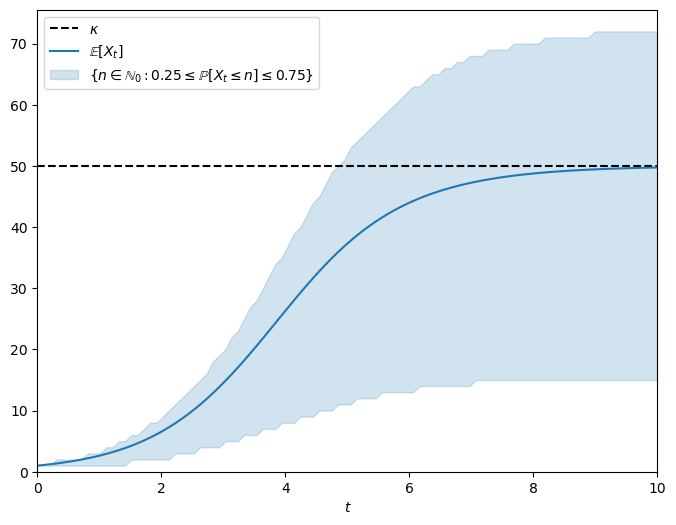

In [49]:
plt.figure(figsize=(8, 6))
plt.axhline(κ, color="k", linestyle="--", label="$\kappa$")
plt.plot(sol.ts, mean_trajectory, label="$\mathbb{E}[X_t]$")
plt.fill_between(sol.ts, *quantile_trajectories, alpha=0.2, color="C0", label="$\{n\in\mathbb{N}_0: 0.25\leq\\mathbb{P}[X_t\leq n]\leq 0.75\}$")
plt.xlabel("$t$")
plt.legend(loc="upper left")
plt.xlim(sol.ts[0], sol.ts[-1])
plt.ylim(0, None)
plt.show()

Note that the process above, with interaction mediated by $\mathbb{E}_p(t)[X_t]$ can transiently exceed the specified carrying capacity $\kappa$, whereas the corresponding process with interaction mediated directly by $X_n$ would be strictly bounded by $\kappa$.

## Possible next steps

- Find the stationary distribution for $t\rightarrow\infty$
- Compare to Monte Carlo simulations:
  - Using the empirical measure from an $N$-system, and explore convergence as $N\rightarrow\infty$
  - Using the empirical population size in the focal system. I think this may be poorly approximated, because small size at small times means we have large fluctuations that are not captured by the mean-field approximation. On the other hand, if $\kappa$ is large, then the interaction is weak during the initial period of large fluctuations, so maybe it's not so bad.
- Characterize sensitivity to state-space truncation